# Network Intrusion Detection System

**Business Problem :** 
1. Binomial Classification: Activity is normal or attack
2. Multinomial classification: Activity is normal or DOS or PROBE or R2L or U2R

**Approach:**

**1 Importing and understanding the data** <br>
> - Importing the Train and Test
- seggregating the attack type variables

**2 Data audit** <br>
**3 Data preparation** <br>
> - Encoding the attack type variable [Bi class]
> - Handling and one hot encoding of categorical variables [Bi class]

> - Encoding the attack type variable [Multi class]
> - Handling and one hot encoding of categorical variables [Multi class]

> - Deriving X and Y of [Bi/Multi class]

**Feature Selection** <br>
> Considering only Xs (Common for both Bi and Multi class)
>    > - VIF (Variance Inflation Factor)
>    > - PCA (Principal Component Analysis)

> Considering X and Binomial Y
>    > - Correlation
>    > - F Regression
>    > - RFE 

**Part I Binomial Classification** <br>
> - Random Forest
> - XGBoost

**Part II Multinomial Classification** <br>
> - Preparing Y multi for skmultilearn
> - Preparing Y multi for sklearn <br>

> Feature Reduction considering both X and Y multi<br>
> - Decision Tree feature importance

> Model Implementation
> - Binary Relevance <br>
> - Classifier chains <br>
> - Random Forest <br>
> - XGBoost <br>
> - Naive Bayes <br>

### ----------------------------------------------------------------------------------------------------------------------------

**1 Importing and understanding the data**

In [1]:
import pandas as pd
import numpy as np
import re
import time

In [2]:
train = pd.read_csv(r'Train.txt',header=None)
test = pd.read_csv(r'Test.txt',header=None)

In [3]:
cols = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [4]:
train.columns = cols
test.columns = cols

In [5]:
train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19


In [6]:
test.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal,21


Segregating the Dataset based on Data Dictionary

In [7]:
basic_features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent']

In [8]:
content_features = ['hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login']

In [9]:
time_features = ['count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate']

In [10]:
host_features = ['dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [11]:
train.columns.difference(basic_features+content_features+time_features+host_features)

Index(['attack', 'last_flag'], dtype='object')

Segregating the Attack type

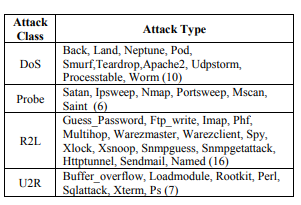

In [12]:
train.attack.unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [13]:
DoS = ['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']
Probe = ['satan','ipsweep','nmap','portsweep','mscan','saint']
R2L = ['mailbomb','guess_passwd','ftp_write','imap','warezmaster','spy','warezclient','multihop','phf','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']
U2R = ['buffer_overflow','loadmodule','perl','sqlattack','xterm','ps','rootkit']

In [14]:
l_attack = []
for i in DoS:
    if i in train.attack.unique():
        l_attack.append(i)
for j in Probe:
    if j in train.attack.unique():
        l_attack.append(j)
for k in R2L:
    if k in train.attack.unique():
        l_attack.append(k)
for l in U2R:
    if l in train.attack.unique():
        l_attack.append(l)
                        
print(l_attack)   

['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'satan', 'ipsweep', 'nmap', 'portsweep', 'guess_passwd', 'ftp_write', 'imap', 'warezmaster', 'spy', 'warezclient', 'multihop', 'phf', 'buffer_overflow', 'loadmodule', 'perl', 'rootkit']


In [15]:
for i in list(train.attack.unique()):
    if i not in l_attack:
        print(i)

normal


#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Data Audit**

check for duplicate rows

In [16]:
train.duplicated().value_counts()

False    125973
dtype: int64

check for missing values

In [17]:
train.isnull().sum().value_counts()

0    43
dtype: int64

## Data Preparation

finding the binary catagorical variables

In [18]:
def binr(x):
    if x.value_counts().count() == 2:
        print(x.name)
        
train.apply(binr);

land
logged_in
root_shell
is_host_login
is_guest_login


Encoding the Attack Type variables (For the multi)<br>
>Normal<br>
>DoS<br>
>Probe <br>
>R2L <br>
>U2R

In [19]:
train_mul = train.copy()
test_mul = test.copy()

In [20]:
train_mul['attack_type'] = np.where((train_mul.attack.isin(DoS)),'dos',
                               np.where((train_mul.attack.isin(Probe)),'probe',
                                        np.where((train_mul.attack.isin(R2L)),'r2l',
                                                np.where((train_mul.attack.isin(U2R)),'u2r',
                                                         np.where((train_mul.attack =='normal'),'normal','x')))))

In [21]:
#print(train_mul.attack.value_counts())
print(train_mul.attack_type.value_counts())

normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_type, dtype: int64


In [22]:
test_mul['attack_type'] = np.where((test_mul.attack.isin(DoS)),'dos',
                               np.where((test_mul.attack.isin(Probe)),'probe',
                                        np.where((test_mul.attack.isin(R2L)),'r2l',
                                                np.where((test_mul.attack.isin(U2R)),'u2r',
                                                          np.where((test_mul.attack =='normal'),'normal','x')))))

In [23]:
#print(test_mul.attack.value_counts())
test_mul.attack_type.value_counts()

normal    9711
dos       7167
r2l       3178
probe     2421
u2r         67
Name: attack_type, dtype: int64

In [24]:
print(list(set(test_mul.attack.unique()) - set(train_mul.attack.unique())))

['httptunnel', 'mscan', 'sqlattack', 'processtable', 'xsnoop', 'snmpgetattack', 'xlock', 'sendmail', 'xterm', 'worm', 'udpstorm', 'mailbomb', 'saint', 'snmpguess', 'apache2', 'ps', 'named']


In [25]:
train_mul.drop(columns=['attack','service'],inplace=True)  #service is dropped due to high cardinality
test_mul.drop(columns=['attack','service'],inplace=True)   

Handling the catagorical variables

In [26]:
train_mul.dtypes[train_mul.dtypes == 'object']

protocol_type    object
flag             object
attack_type      object
dtype: object

In [27]:
y_atk_mul_train = train_mul['attack_type']
y_atk_mul_test = test_mul['attack_type']
cat_vars = ['protocol_type','flag','attack_type']

In [28]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

for c_feature in cat_vars:
    train_mul[c_feature]=train_mul[c_feature].astype('category')
    train_mul=create_dummies(train_mul,c_feature)
for c_feature in cat_vars:
    test_mul[c_feature]=test_mul[c_feature].astype('category')
    test_mul=create_dummies(test_mul,c_feature)

In [29]:
train_mul.shape, test_mul.shape

((125973, 55), (22544, 55))

In [30]:
train_mul.columns[~train_mul.columns.isin(test_mul.columns)]

Index([], dtype='object')

### ----------------------------------------------------------------------------------------------------------------------------

Encoding the Attack Type variables (For the Bi)<br>
>Normal<br>

below all are classified as the error <br>
>DoS<br>
>Probe <br>
>R2L <br>
>U2R

In [31]:
train_bi = train.copy()
test_bi = test.copy()

In [32]:
train_bi['attack_type'] = np.where((train_bi.attack =='normal'),'normal','error')
test_bi['attack_type'] = np.where((test_bi.attack =='normal'),'normal','error')

In [33]:
#print(train_bi.attack.value_counts())
print(train_bi.attack_type.value_counts())

normal    67343
error     58630
Name: attack_type, dtype: int64


In [34]:
#print(test_bi.attack.value_counts())
test_bi.attack_type.value_counts()

error     12833
normal     9711
Name: attack_type, dtype: int64

In [35]:
print(list(set(test_bi.attack.unique()) - set(train_bi.attack.unique())))

['httptunnel', 'mscan', 'sqlattack', 'processtable', 'xsnoop', 'snmpgetattack', 'xlock', 'sendmail', 'xterm', 'worm', 'udpstorm', 'mailbomb', 'saint', 'snmpguess', 'apache2', 'ps', 'named']


In [36]:
train_bi.drop(columns=['attack','service'],inplace=True)  #service is dropped due to high cardinality
test_bi.drop(columns=['attack','service'],inplace=True)   

Handling the catagorical variables

In [37]:
train_bi.dtypes[train_bi.dtypes == 'object']

protocol_type    object
flag             object
attack_type      object
dtype: object

In [38]:
cat_vars = ['protocol_type','flag','attack_type']

In [39]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

for c_feature in cat_vars:
    train_bi[c_feature]=train_bi[c_feature].astype('category')
    train_bi=create_dummies(train_bi,c_feature)
for c_feature in cat_vars:
    test_bi[c_feature]=test_bi[c_feature].astype('category')
    test_bi=create_dummies(test_bi,c_feature)

In [40]:
train_bi.shape, test_bi.shape

((125973, 52), (22544, 52))

In [41]:
train_bi.columns[~train_bi.columns.isin(test_bi.columns)]

Index([], dtype='object')

### ----------------------------------------------------------------------------------------------------------------------------

Separating Y and X for both Bi and Multi class

In [42]:
X_train = train_bi[train_bi.columns.difference(['attack_type_normal'])]
X_test = test_bi[test_bi.columns.difference(['attack_type_normal'])]

In [43]:
Y_train_bi = train_bi['attack_type_normal']
Y_test_bi = test_bi['attack_type_normal']

In [44]:
Y_train_mul = train_mul[['attack_type_normal','attack_type_probe','attack_type_r2l','attack_type_u2r']]
Y_test_mul = test_mul[['attack_type_normal','attack_type_probe','attack_type_r2l','attack_type_u2r']]

### ----------------------------------------------------------------------------------------------------------------------------

## Feature Selection 

### Considering only the Xs variables

**// This part is common for both the Binomial and Multinomial Classification //**

The following the feature selection methods will be performed <br>

> VIF <br>
> PCA

In [45]:
X = X_train.copy()

### VIF

In [46]:
#VIF_results.to_excel('VIF_NetDet.xlsx')

In [47]:
selected_vars_vif = ['num_root','num_compromised','srv_serror_rate','flag_S0','serror_rate','flag_SF','srv_rerror_rate','last_flag','dst_host_srv_serror_rate','flag_REJ','rerror_rate','protocol_type_tcp','dst_host_serror_rate','same_srv_rate','dst_host_same_srv_rate','dst_host_srv_rerror_rate','flag_RSTR','logged_in','dst_host_srv_count','flag_RSTO','dst_host_rerror_rate','dst_host_count','count','protocol_type_udp']

In [48]:
len(selected_vars_vif)

24

### PCA

**1 Splitting the dataset if required**

**2 Feature scaling**

fit() ------------------> just calculates the parameters (e.g. μ and σ in case of StandardScaler) <br>
transform() ------------> helps to apply the scaling based on the calculated parameters from fit()

**3 Applying PCA** 

**3.1** Eigen value

**3.2** Variance explained by each PC in Cumulative Percentage 

**3.3** Selecting the Number of Principal components based on <br>
Cumulative percentage of variance > 75% <br>
Eigen value > 0.8

Based on the above criteria for selection we conclude **Number of PC = 24** 

**3.4** Fitting the model again with the select number PC

**3.5** Dimension Reduction 

**3.6** Factor Loading Matrix / Component loadings

Loadings=Eigenvectors * sqrt(Eigenvalues)

Factor loadings are the covariances/correlations between the original variables and the unit-scaled components. (i.e., PCs ~ Initial Columns ) <br>

Factors Loadings are the percent of variance in a variable explained by the factor

In [49]:
#Factor_loading_matrix.to_excel('Factor_Loading_matrix_NetDet.xlsx')

**3.7** Selecting the Features based on the factor loadings

In [50]:
selected_vars_pca = ['count','diff_srv_rate','dst_bytes','dst_host_count','dst_host_diff_srv_rate','dst_host_rerror_rate','dst_host_same_src_port_rate','dst_host_same_srv_rate','dst_host_serror_rate','dst_host_srv_count','dst_host_srv_diff_host_rate','dst_host_srv_rerror_rate','dst_host_srv_serror_rate','duration','flag_REJ','flag_RSTO','flag_RSTOS0','flag_RSTR','flag_S0','flag_S1','flag_S2','flag_S3','flag_SF','flag_SH']

In [51]:
len(selected_vars_pca)

24

### ----------------------------------------------------------------------------------------------------------------------------

### Considering the both X and Binomial Y

The following methods below are used, <br>
> Correlation b/w X and Y <br>
> F regression <br>
> RFE

**Y_bi --> 1 - Normal | 0 - Error**

### Correlation b/w X and Y

In [52]:
selected_vars_corr = np.abs(X.corrwith(Y_train_bi)).sort_values(ascending=False).head(12)
selected_vars_corr = list(selected_vars_corr.index)

The above 12 variables exhibit high correlation with the binomial Y

### F-Regression

In [53]:
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression(X, Y_train_bi ) # Will give two arrays of f and p values

C:\Users\guru\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\guru\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\guru\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\guru\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [54]:
F_values = pd.Series(F_values)
p_values = pd.Series(p_values)
cols = pd.Series(X.columns)

f_vars = pd.concat([cols,F_values,p_values],axis=1)
f_vars.columns = ['col','f_val','p_val']

In [55]:
f_vars = f_vars.sort_values(by=['f_val'],ascending=False)

In [56]:
selected_vars_freg = list(f_vars.col.head(11))

#### RFE

In [57]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

In [58]:
dt = DecisionTreeRegressor()

In [59]:
rfe = RFE(dt, n_features_to_select=10)
rfe = rfe.fit(X,Y_train_bi)

In [60]:
select_cols = rfe.get_support()
selected_vars_rfe = list(X.columns[select_cols])

Making the final combination of selected variables

In [61]:
selected_vars_final_bi = list(set(selected_vars_corr + selected_vars_freg + selected_vars_pca + selected_vars_rfe + selected_vars_vif))

In [62]:
len(selected_vars_final_bi)

37

In [63]:
X_train_bi = X_train[selected_vars_final_bi]
X_test_bi = X_test[selected_vars_final_bi]

### Part I -  Binomial Classification:
(Activity is normal or attack)

Binomial Classification used here are, <br>
> Random Forest <br>
> XGBoost <br>

Checking the % of 0s and 1s in Y_bi (train / test)

In [64]:
Y_train_bi[Y_train_bi==0].shape[0]/Y_train_bi.shape[0] , Y_train_bi[Y_train_bi==1].shape[0]/Y_train_bi.shape[0]

(0.4654171925730117, 0.5345828074269883)

In [65]:
Y_test_bi[Y_test_bi==0].shape[0]/Y_test_bi.shape[0] , Y_test_bi[Y_test_bi==1].shape[0]/Y_test_bi.shape[0]

(0.5692423704755145, 0.43075762952448543)

***Since the percentage of 0s and 1s are almost equal we can proceed without performing the over/under sampling. We will be setting the Optimum Cut-off as 0.5***

Train and Test split

In [66]:
#Importing packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [67]:
def mod_eva(y_train,y_test,pred_train,pred_test,c):
    print('train :','\n',confusion_matrix(y_train,pred_train))
    print('test :','\n',confusion_matrix(y_test,pred_test))
    print('Accuracy train : ', metrics.accuracy_score(y_train,pred_train))
    print('Accuracy test  : ',metrics.accuracy_score(y_test,pred_test))
    if c=='b':
        train_gini = 2*metrics.roc_auc_score(y_train, pred_train) - 1
        print("Gini train : ", train_gini)
        test_gini = 2*metrics.roc_auc_score(y_test, pred_test) - 1
        print("Gini test  : ", test_gini)
        train_auc = metrics.roc_auc_score(y_train,pred_train)
        test_auc = metrics.roc_auc_score(y_test,pred_test)
        print("AUC Train : ", train_auc)
        print("AUC Test  : ", test_auc)

### Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
start_time = time.time()
pargrid_ada = {'n_estimators': [50],
               'max_depth':[6]}

g_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=3,n_jobs=-1)
g_rf.fit(X_train_bi, Y_train_bi)
print("--- %s seconds ---" % (time.time() - start_time))

--- 15.31787633895874 seconds ---


In [70]:
g_rf.best_params_

{'max_depth': 6, 'n_estimators': 50}

In [71]:
#Predicting values for both training and testing data sets
rf_train_pred=g_rf.predict(X_train_bi)
rf_test_pred=g_rf.predict(X_test_bi)

In [72]:
mod_eva(Y_train_bi,Y_test_bi,rf_train_pred,rf_test_pred,'b')

train : 
 [[58046   584]
 [  383 66960]]
test : 
 [[9119 3714]
 [ 281 9430]]
Accuracy train :  0.9923237519150929
Accuracy test  :  0.8227909865152591
Gini train :  0.9843519267456353
Gini test  :  0.6816536275996496
AUC Train :  0.9921759633728177
AUC Test  :  0.8408268137998248


### XGBoost

In [73]:
import xgboost

In [74]:
start_time = time.time()
pargrid_xg = {'n_estimators': [50],
               'max_depth':[8]}
gscv_xg = GridSearchCV(estimator=xgboost.XGBClassifier(), 
                        param_grid=pargrid_xg, 
                        cv=3,n_jobs=-1)
xg=gscv_xg.fit(X_train_bi, Y_train_bi)
print("--- %s seconds ---" % (time.time() - start_time))

--- 45.15458273887634 seconds ---


In [75]:
xg.best_params_

{'max_depth': 8, 'n_estimators': 50}

In [76]:
#Predicting values for both training and testing data sets
xg_train_pred=xg.predict(X_train_bi)
xg_test_pred=xg.predict(X_test_bi)

In [77]:
mod_eva(Y_train_bi,Y_test_bi,xg_train_pred,xg_test_pred,'b')

train : 
 [[58616    14]
 [   11 67332]]
test : 
 [[8936 3897]
 [ 267 9444]]
Accuracy train :  0.9998015447754678
Accuracy test  :  0.8152945351312988
Gini train :  0.9995978715089435
Gini test  :  0.6688351810396913
AUC Train :  0.9997989357544718
AUC Test  :  0.8344175905198457


**Conclusion on Binomial Classification :** <br>
Both the models Random Forest and XGBoost was performing good.<br>
But the Random Forest model took only 1/5 th of the time for execution comparatively.<br>
Random Forest model can be chosen as the final model for predicting if there is any Anamoly in the Network.

### ----------------------------------------------------------------------------------------------------------------------------

## Part II - Multinomial Classification

**Activity is normal or DOS or PROBE or R2L or U2R**

**Data Preparation**

In [78]:
selected_vars_pca,selected_vars_vif;

In [79]:
X_train;

In [80]:
y_atk_mul_train.value_counts()

normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_type, dtype: int64

In [81]:
y_atk_mul_test.value_counts()

normal    9711
dos       7167
r2l       3178
probe     2421
u2r         67
Name: attack_type, dtype: int64

One Hot Encoding the Y_mul (for skmultilearn algorithms)

In [82]:
y_atk_train_dum = pd.get_dummies(y_atk_mul_train)

In [83]:
y_atk_test_dum = pd.get_dummies(y_atk_mul_test)

Encoding Y_mul(for sklearn algorithms)

In [84]:
y_atk_mul_train_encode = np.where((y_atk_mul_train=='normal'),1,
                               np.where((y_atk_mul_train=='dos'),2,
                                        np.where((y_atk_mul_train=='probe'),3,
                                                np.where((y_atk_mul_train=='r2l'),4,
                                                          np.where((y_atk_mul_train=='u2r'),5,'x'))))) 

In [85]:
y_atk_mul_train_encode = pd.Series(y_atk_mul_train_encode)

In [86]:
y_atk_mul_test_encode = np.where((y_atk_mul_test=='normal'),1,
                               np.where((y_atk_mul_test=='dos'),2,
                                        np.where((y_atk_mul_test=='probe'),3,
                                                np.where((y_atk_mul_test=='r2l'),4,
                                                          np.where((y_atk_mul_test=='u2r'),5,'x'))))) 

In [87]:
y_atk_mul_test_encode = pd.Series(y_atk_mul_test_encode)

#### Feature Reduction using Decision Tree

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:
dt = DecisionTreeClassifier( max_depth = 7, max_features=40 )

In [90]:
dt.fit( X_train, y_atk_mul_train_encode )

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=40, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [91]:
feat_imp = pd.concat([pd.Series(X_train.columns),pd.Series(dt.feature_importances_)],axis=1)

In [92]:
print(list(feat_imp.sort_values(by=1,ascending=False)[0].head(24)))

['src_bytes', 'count', 'last_flag', 'dst_host_diff_srv_rate', 'dst_host_srv_count', 'protocol_type_tcp', 'dst_host_same_src_port_rate', 'dst_host_srv_serror_rate', 'dst_host_same_srv_rate', 'dst_bytes', 'dst_host_count', 'wrong_fragment', 'flag_S0', 'dst_host_serror_rate', 'srv_count', 'dst_host_rerror_rate', 'protocol_type_udp', 'diff_srv_rate', 'duration', 'logged_in', 'serror_rate', 'srv_rerror_rate', 'srv_serror_rate', 'same_srv_rate']


In [93]:
s = ['src_bytes', 'dst_host_same_src_port_rate', 'count', 'last_flag', 'diff_srv_rate', 'wrong_fragment', 'dst_host_count', 'flag_S0', 'dst_host_srv_serror_rate', 'dst_host_same_srv_rate', 'dst_bytes', 'protocol_type_tcp', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'logged_in', 'srv_count', 'dst_host_serror_rate', 'protocol_type_udp', 'srv_serror_rate', 'rerror_rate', 'flag_RSTO', 'duration', 'flag_RSTR']

In [94]:
selected_vars_ftimp = ['src_bytes', 'dst_host_same_src_port_rate', 'count', 'last_flag', 'diff_srv_rate', 'wrong_fragment', 'dst_host_count', 'flag_S0', 'dst_host_srv_serror_rate', 'dst_host_same_srv_rate', 'dst_bytes', 'protocol_type_tcp', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'logged_in', 'srv_count', 'dst_host_serror_rate', 'protocol_type_udp', 'srv_serror_rate', 'rerror_rate', 'flag_RSTO', 'duration', 'flag_RSTR']

In [95]:
selected_vars_final_mul = list(set(selected_vars_pca + selected_vars_vif + selected_vars_ftimp))

In [96]:
X_final_mul_train = X_train[selected_vars_final_mul]
X_final_mul_test = X_test[selected_vars_final_mul]

### Model Implementation 
(Multi Class)

> Binary Relevance <br>
> Classifier chains <br>
> Random Forest <br>
> XGBoost <br>
> Naive Bayes <br>

**Binary Relevance**

In [97]:
#pip install scikit-multilearn

In [98]:
# using binary relevance
import skmultilearn
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(X_final_mul_train, y_atk_train_dum)

BinaryRelevance(classifier=GaussianNB(priors=None, var_smoothing=1e-09),
                require_dense=[True, True])

In [99]:
predictions = classifier.predict(X_final_mul_train)

In [100]:
accuracy_score(y_atk_train_dum,predictions)

0.01820231319409715

**Classifier chains**

In [101]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(X_final_mul_train, y_atk_train_dum)

# predict
predictions = classifier.predict(X_final_mul_train)

accuracy_score(y_atk_train_dum,predictions)

0.01820231319409715

**Random Forest**

In [102]:
from sklearn.model_selection import GridSearchCV

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
start_time = time.time()
pargrid_ada = {'max_depth': [8], 'n_estimators': [50]}
data_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,n_jobs=-1)
data_rf.fit(X_final_mul_train, y_atk_mul_train_encode)
print("--- %s seconds ---" % (time.time() - start_time))

--- 23.896366834640503 seconds ---


In [105]:
data_rf.best_params_

{'max_depth': 8, 'n_estimators': 50}

In [106]:
#Predicting values for both training and testing data sets
rf_train_pred=data_rf.predict(X_final_mul_train)
rf_test_pred=data_rf.predict(X_final_mul_test)

In [107]:
mod_eva(y_atk_mul_train_encode,y_atk_mul_test_encode,rf_train_pred,rf_test_pred,'m')

train : 
 [[67285     0    36    22     0]
 [   56 45868     3     0     0]
 [   88     0 11568     0     0]
 [  162     0     0   833     0]
 [   34     0     2     0    16]]
test : 
 [[9449   55  207    0    0]
 [1190 5943   34    0    0]
 [ 623  239 1559    0    0]
 [2998    0  172    8    0]
 [  65    0    0    0    2]]
Accuracy train :  0.9968009017805403
Accuracy test  :  0.7523509581263307


**XGBoost**

In [108]:
import xgboost

In [109]:
start_time = time.time()
pargrid_xg = {'n_estimators': [50],
               'max_depth':[8]}
gscv_xg = GridSearchCV(estimator=xgboost.XGBClassifier(), 
                        param_grid=pargrid_xg, 
                        cv=3,n_jobs=-1)
xg=gscv_xg.fit(X_final_mul_train, y_atk_mul_train_encode)
print("--- %s seconds ---" % (time.time() - start_time))

--- 202.21156573295593 seconds ---


In [110]:
xg.best_params_

{'max_depth': 8, 'n_estimators': 50}

In [111]:
#Predicting values for both training and testing data sets
xg_train_pred=xg.predict(X_final_mul_train)
xg_test_pred=xg.predict(X_final_mul_test)

In [112]:
mod_eva(y_atk_mul_train_encode,y_atk_mul_test_encode,xg_train_pred,xg_test_pred,'m')

train : 
 [[67337     2     2     2     0]
 [    0 45927     0     0     0]
 [    1     0 11655     0     0]
 [    5     0     0   990     0]
 [    0     0     0     0    52]]
test : 
 [[9442   67  202    0    0]
 [1116 5913   81   55    2]
 [ 734  162 1521    0    4]
 [2416    3  377  308   74]
 [  15    0    4   20   28]]
Accuracy train :  0.9999047414922245
Accuracy test  :  0.7634847409510291


**Naive Bayes**

In [113]:
from sklearn.naive_bayes import GaussianNB

In [114]:
nb_clf = GaussianNB()
nb_clf.fit(X_final_mul_train, y_atk_mul_train_encode)

GaussianNB(priors=None, var_smoothing=1e-09)

In [115]:
nb_train_pred=nb_clf.predict(X_final_mul_train)
nb_test_pred=nb_clf.predict(X_final_mul_test)

In [116]:
mod_eva(y_atk_mul_train_encode,y_atk_mul_test_encode,nb_train_pred,nb_test_pred,'m')

train : 
 [[ 2690 55955   580   421  7697]
 [  952 44975     0     0     0]
 [  116 10648   891     0     1]
 [   12   875    96     5     7]
 [    3    36     0     0    13]]
test : 
 [[ 310 7918   17   14 1452]
 [ 842 5856  159  310    0]
 [   0 2421    0    0    0]
 [ 241 2926    3    1    7]
 [  12   43    0    0   12]]
Accuracy train :  0.38559056305716305
Accuracy test  :  0.2740862313697658


**Conclusion for Multi Classification :** From all the above models Random Forest and XGBoost perform better than other models giving an ___average test accuracy of 75%___. Since the Random Forest model is more time efficient, we will choose the Random Forest as the final model for this dataset.

### ----------------------------------------------------------------------------------------------------------------------------